In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('final_matches.csv')

# Inspect the data
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 Rows:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())

# Handle missing values
df['attendance'] = df['attendance'].fillna(0)  # Assume 0 for missing attendance (e.g., COVID-era games)
df['xg'] = df['xg'].fillna(df['xg'].mean())  # Impute xG with mean
df['xga'] = df['xga'].fillna(df['xga'].mean())  # Impute xGA with mean
df['poss'] = df['poss'].fillna(df['poss'].mean())  # Impute possession with mean

# Standardize team names
team_mapping = {
    'Wolverhampton Wanderers': 'Wolves',
    'Manchester United': 'Manchester Utd',
    'Nottingham Forest': "Nott'ham Forest",
    'Tottenham Hotspur': "Tottenham"
     
}
df['team'] = df['team'].replace(team_mapping)
df['opponent'] = df['opponent'].replace(team_mapping)

# Add points column (W=3, D=1, L=0)
def calculate_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

df['points'] = df['result'].apply(calculate_points)

# Verify cleaning
print("\nCleaned Dataset Info:")
print(df[['team', 'opponent', 'result', 'points', 'xg', 'poss']].head())

Dataset Shape: (3800, 28)

Columns: ['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'team', 'season']

First 5 Rows:
          date   time            comp        round  day venue result  gf  ga  \
0  2020-09-12  12:30  Premier League  Matchweek 1  Sat  Away      W   3   0   
1  2020-09-19  20:00  Premier League  Matchweek 2  Sat  Home      W   2   1   
2  2020-09-28  20:00  Premier League  Matchweek 3  Mon  Away      L   1   3   
3  2020-10-04  14:00  Premier League  Matchweek 4  Sun  Home      W   2   1   
4  2020-10-17  17:30  Premier League  Matchweek 5  Sat  Away      L   0   1   

          opponent  ...  match report  notes    sh  sot  dist   fk pk pkatt  \
0           Fulham  ...  Match Report    NaN  13.0  5.0  14.1  2.0  0     0   
1         West Ham  ...  Match Report    NaN   7.0  3.0  14

In [2]:
import pandas as pd

# Show all rows (or set a big number)
pd.set_option('display.max_rows', 1000)

# Show all columns
pd.set_option('display.max_columns', None)

# Avoid truncating column width
pd.set_option('display.max_colwidth', None)


In [3]:
# Aggregate match data to team-season level
team_stats = df.groupby(['team', 'season']).agg({
    'points': 'sum',  # Total points per season
    'gf': 'mean',     # Average goals for
    'ga': 'mean',     # Average goals against
    'xg': 'mean',     # Average expected goals
    'xga': 'mean',    # Average expected goals against
    'poss': 'mean',   # Average possession
    'sh': 'mean',     # Average shots
    'sot': 'mean'     # Average shots on target
}).reset_index()

# Calculate form (average points over last 5 matches)
def calculate_form(group):
    group['form_last_5'] = group['points'].rolling(window=5, min_periods=1).mean().shift(1)
    return group

df = df.groupby('team').apply(calculate_form).reset_index(drop=True)
form_stats = df.groupby(['team', 'season'])['form_last_5'].mean().reset_index()

# Merge form with team stats
team_stats = team_stats.merge(form_stats, on=['team', 'season'], how='left')
team_stats['form_last_5'] = team_stats['form_last_5'].fillna(team_stats['form_last_5'].mean())

# Add goal difference
team_stats['goal_diff'] = team_stats['gf'] - team_stats['ga']
df['shot_conversion']=df['sot' ]/ df['sh']

# Verify features
print("\nTeam-Season Features:\n", team_stats)
print(df.head)
print(df.iloc[:100])  # first 100 rows
print(df.iloc[100:200])  # next 100 rows


C:\Users\HP\AppData\Local\Temp\ipykernel_17512\3814927783.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team').apply(calculate_form).reset_index(drop=True)



Team-Season Features:
                         team  season  points        gf        ga        xg  \
0                    Arsenal    2021      61  1.447368  1.026316  1.363158   
1                    Arsenal    2022      69  1.605263  1.263158  1.589474   
2                    Arsenal    2023      84  2.315789  1.131579  1.878947   
3                    Arsenal    2024      89  2.394737  0.763158  2.007895   
4                    Arsenal    2025      74  1.815789  0.894737  1.578947   
5                Aston Villa    2021      55  1.447368  1.210526  1.386842   
6                Aston Villa    2022      45  1.368421  1.421053  1.155263   
7                Aston Villa    2023      61  1.342105  1.210526  1.321053   
8                Aston Villa    2024      68  2.000000  1.605263  1.671053   
9                Aston Villa    2025      66  1.526316  1.342105  1.473684   
10               Bournemouth    2023      39  0.973684  1.868421  1.005263   
11               Bournemouth    2024    

In [4]:
unwanted_columns = ['date', 'time', 'comp', 'round', 'day', 'referee', 
                    'match report', 'notes', 'captain', 'attendance']

df = df.drop(columns=unwanted_columns)


In [5]:
print(df)

     venue result  gf  ga         opponent   xg  xga  poss formation  \
0     Away      W   3   0           Fulham  1.9  0.1  54.0     3-4-3   
1     Home      W   2   1         West Ham  1.1  2.0  62.0     3-4-3   
2     Away      L   1   3        Liverpool  1.3  2.7  34.0     3-4-3   
3     Home      W   2   1    Sheffield Utd  0.6  0.2  64.0     4-3-3   
4     Away      L   0   1  Manchester City  0.9  1.3  42.0     4-3-3   
...    ...    ...  ..  ..              ...  ...  ...   ...       ...   
3795  Home      W   3   0   Leicester City  2.0  1.1  56.0     3-4-3   
3796  Away      L   0   1  Manchester City  0.4  0.7  37.0     3-4-3   
3797  Home      L   0   2         Brighton  0.9  1.6  56.0     3-4-3   
3798  Away      L   2   4   Crystal Palace  1.4  1.7  69.0     3-4-3   
3799  Home      D   1   1        Brentford  1.0  1.4  49.0     3-4-3   

     opp formation    sh  sot  dist   fk  pk  pkatt     team  season  points  \
0          4-2-3-1  13.0  5.0  14.1  2.0   0      0  Ar

In [6]:
print(df.columns.tolist())


['venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'formation', 'opp formation', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'team', 'season', 'points', 'form_last_5', 'shot_conversion']


In [7]:
df = df.drop(columns=['formation', 'opp formation'])


In [8]:
df.isnull().sum()

venue               0
result              0
gf                  0
ga                  0
opponent            0
xg                  0
xga                 0
poss                0
sh                  0
sot                 0
dist                1
fk                  0
pk                  0
pkatt               0
team                0
season              0
points              0
form_last_5        27
shot_conversion     1
dtype: int64

In [9]:
df[['dist', 'xg', 'gf', 'shot_conversion']].corr()


,dist,xg,gf,shot_conversion
dist,1.000000,-0.275874,-0.165093,-0.122700
xg,-0.275874,1.000000,0.612394,0.121680
gf,-0.165093,0.612394,1.000000,0.381189
shot_conversion,-0.122700,0.121680,0.381189,1.000000


In [10]:
df['dist'] = df['dist'].fillna(df['dist'].mean())

df['form_last_5'] = df['form_last_5'].fillna(df['form_last_5'].mean())


In [11]:
mask = (df['shot_conversion'].isna()) & (df['sh'] != 0)
df.loc[mask, 'shot_conversion'] = df.loc[mask, 'sot'] / df.loc[mask, 'sh']

# Fill any remaining with 0
df['shot_conversion'] = df['shot_conversion'].fillna(0)


In [12]:
df.isnull().sum()

venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
sh                 0
sot                0
dist               0
fk                 0
pk                 0
pkatt              0
team               0
season             0
points             0
form_last_5        0
shot_conversion    0
dtype: int64

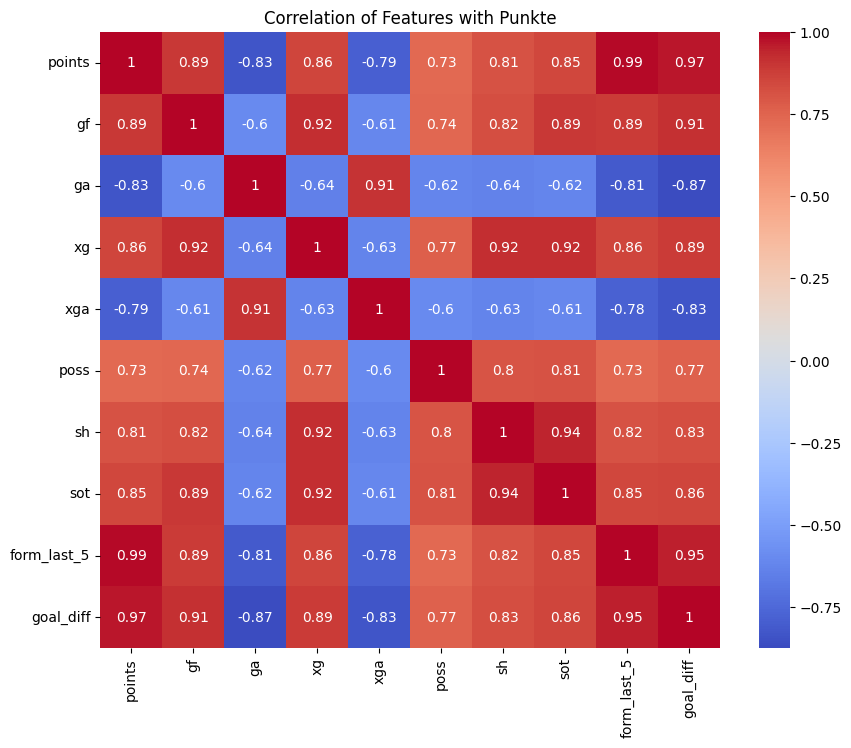

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(team_stats[['points', 'gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'form_last_5', 'goal_diff']].corr(),
            annot=True , cmap='coolwarm')
plt.title('Correlation of Features with Punkte')
plt.show()

🏆 Predicted Winner (2021): Manchester City with 85.97 points
🏆 Predicted Winner (2022): Manchester City with 92.80 points
🏆 Predicted Winner (2023): Manchester City with 89.06 points
🏆 Predicted Winner (2024): Manchester City with 90.96 points
🏆 Predicted Winner (2025): Liverpool with 84.16 points

📊 Overall Mean Absolute Error (All Seasons): 0.09 points


<Figure size 1000x600 with 0 Axes>

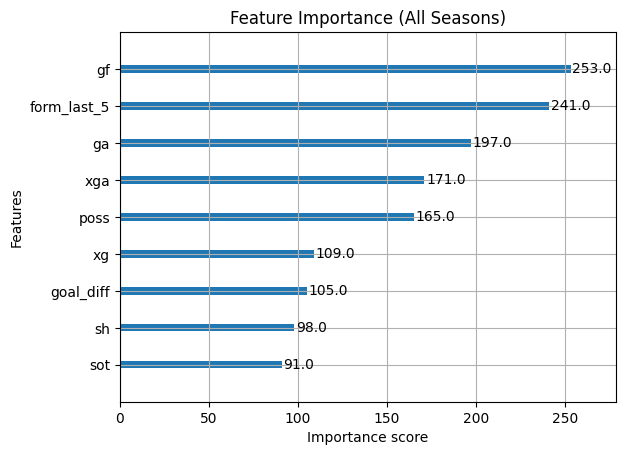

In [15]:
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Define your features and target
features = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'form_last_5', 'goal_diff']
X = team_stats[features]
y = team_stats['points']

# Train on the full dataset
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

model.fit(X, y)

# Predict on entire dataset
team_stats = team_stats.copy()  # just to be safe
team_stats['predicted_points'] = model.predict(X)

# Show predictions by season, top team each year
for season in sorted(team_stats['season'].unique()):
    season_data = team_stats[team_stats['season'] == season]
    top_team = season_data.sort_values(by='predicted_points', ascending=False).iloc[0]
    print(f"🏆 Predicted Winner ({season}): {top_team['team']} with {top_team['predicted_points']:.2f} points")

# Optional: Evaluate error
mae_all = mean_absolute_error(team_stats['points'], team_stats['predicted_points'])
print(f"\n📊 Overall Mean Absolute Error (All Seasons): {mae_all:.2f} points")

# Optional: Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance (All Seasons)')
plt.show()



In [16]:
actual_winners = team_stats.loc[team_stats.groupby('season')['points'].idxmax(), ['season', 'team', 'points']]
predicted_winners = team_stats.loc[team_stats.groupby('season')['predicted_points'].idxmax(), ['season', 'team', 'predicted_points']]

comparison = actual_winners.merge(predicted_winners, on='season', suffixes=('_actual', '_predicted'))
print(comparison)


   season      team_actual  points   team_predicted  predicted_points
0    2021  Manchester City      86  Manchester City         85.970581
1    2022  Manchester City      93  Manchester City         92.798698
2    2023  Manchester City      89  Manchester City         89.055122
3    2024  Manchester City      91  Manchester City         90.964645
4    2025        Liverpool      84        Liverpool         84.158554


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
🏆 DL Predicted Winner (2021): Manchester City with 86.82 points
🏆 DL Predicted Winner (2022): Liverpool with 98.01 points
🏆 DL Predicted Winner (2023): Manchester City with 92.89 points
🏆 DL Predicted Winner (2024): Manchester City with 93.28 points
🏆 DL Predicted Winner (2025): Liverpool with 86.47 points

📊 Deep Learning MAE (All Seasons): 3.06 points


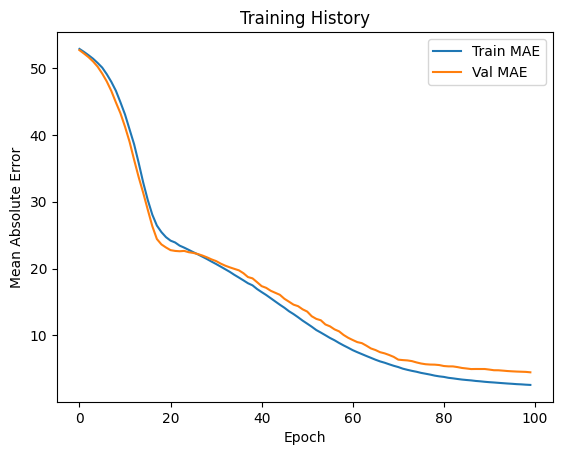

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Define features and target
features = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'form_last_5', 'goal_diff']
X = team_stats[features].copy()
y = team_stats['points'].copy()

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Build the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # regression output
])

# 5. Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6. Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=0)

# 7. Predict on all data
team_stats['predicted_points_dl'] = model.predict(X_scaled).flatten()

# 8. Print predicted winners per season
for season in sorted(team_stats['season'].unique()):
    season_data = team_stats[team_stats['season'] == season]
    top_team = season_data.sort_values(by='predicted_points_dl', ascending=False).iloc[0]
    print(f"🏆 DL Predicted Winner ({season}): {top_team['team']} with {top_team['predicted_points_dl']:.2f} points")

# 9. Evaluate
mae_dl = mean_absolute_error(team_stats['points'], team_stats['predicted_points_dl'])
print(f"\n📊 Deep Learning MAE (All Seasons): {mae_dl:.2f} points")

# 10. Plot training curve
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


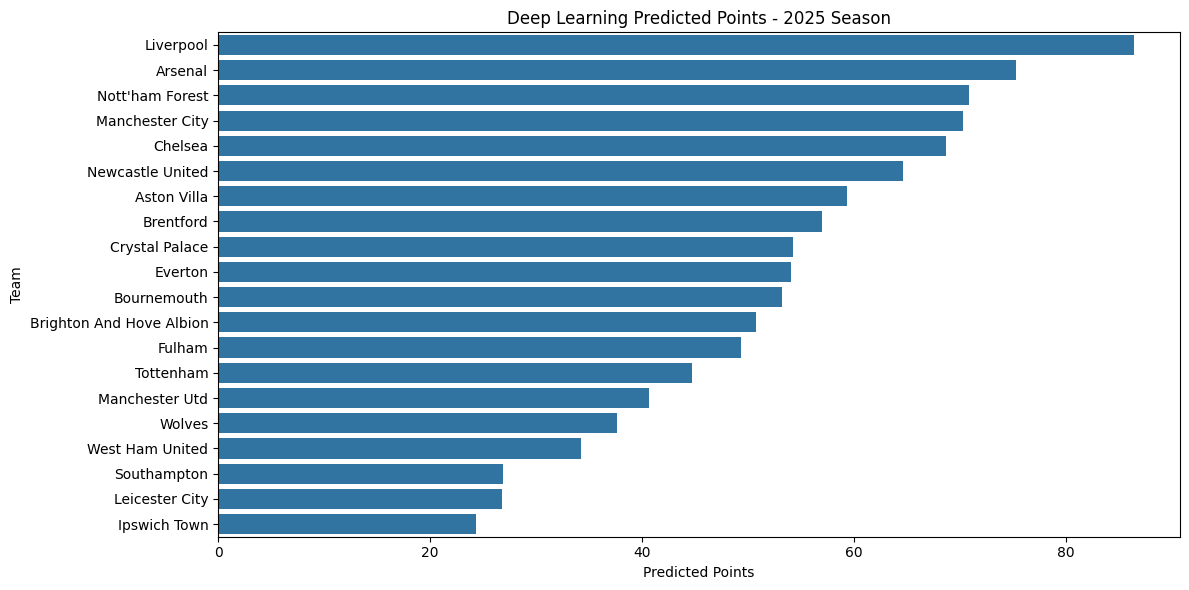

In [19]:
import seaborn as sns

season = 2025
df = team_stats[team_stats['season'] == season].sort_values('predicted_points_dl', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='predicted_points_dl', y='team', data=df)
plt.title(f'Deep Learning Predicted Points - {season} Season')
plt.xlabel('Predicted Points')
plt.ylabel('Team')
plt.tight_layout()
plt.show()
